In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Paired'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'virussign-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from virussign-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(10136, 2048)

In [9]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=10)
top_model.fit(resnet50features,y)  # Training 

Fitting 5 folds for each of 169 candidates, totalling 845 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.138067, total=11.9min
[CV] C=0.01, gamma=1e-07 .............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.138067, total=12.0min
[CV] C=0.01, g

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed: 20.0min


[CV] .............. C=0.01, gamma=1e-08, score=0.138067, total=12.8min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.138067, total=12.7min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138067, total=12.9min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.138067, total=13.0min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138067, total=12.9min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138067, total=12.0min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138067, total=12.1min
[CV] C=0.01, gamma=1e-05 .............................................


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 39.6min


[CV] .............. C=0.01, gamma=1e-07, score=0.138067, total=12.3min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138067, total=12.3min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138067, total=12.3min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138067, total=12.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138067, total=12.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138067, total=12.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138067, total=12.3min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 58.0min


[CV] .............. C=0.01, gamma=1e-05, score=0.138067, total=11.5min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.138067, total=11.5min
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.250000, total=11.5min
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.250493, total=13.3min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.138067, total=13.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.249014, total=13.3min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.138067, total=13.4min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 61.5min


[CV] .............. C=0.01, gamma=0.001, score=0.487673, total= 9.5min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.492110, total= 9.5min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.484221, total= 9.5min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.487179, total= 9.5min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.489152, total=11.4min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.402860, total=13.3min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.394477, total=13.0min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 94.7min


[CV] ................ C=0.01, gamma=0.1, score=0.259862, total=14.2min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.256410, total=14.1min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.254931, total=14.3min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.258876, total=17.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.207594, total=18.5min
[CV] C=0.01, gamma=100.0 .............................................
[CV] ................ C=0.01, gamma=1.0, score=0.211538, total=18.6min
[CV] C=0.01, gamma=100.0 .............................................
[CV] ................ C=0.01, gamma=1.0, score=0.210552, total=18.5min
[CV] C=0.01, gamma=100.0 .............................................
[CV] .

[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 117.2min


[CV] ............... C=0.01, gamma=10.0, score=0.161243, total=15.7min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=10.0, score=0.168146, total=15.6min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=10.0, score=0.171598, total=18.4min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] .............. C=0.01, gamma=100.0, score=0.153846, total=18.9min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.148915, total=18.7min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.150888, total=18.8min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] .............. C=0.01, gamma=100.0, score=0.154339, total=18.6min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] .

[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed: 153.7min


[CV] ............... C=0.1, gamma=1e-09, score=0.138067, total=12.9min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.138067, total=13.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.138067, total=13.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.138067, total=13.0min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............. C=0.01, gamma=1000.0, score=0.155819, total=17.9min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138067, total=11.1min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138067, total=11.0min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed: 175.2min


[CV] ............... C=0.1, gamma=1e-06, score=0.138067, total=11.3min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138067, total=13.5min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.138067, total=11.4min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.138067, total=11.4min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138067, total=13.4min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138067, total=13.3min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.543886, total= 8.3min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed: 195.8min


[CV] ............... C=0.1, gamma=1e-05, score=0.249014, total=12.9min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=0.001, score=0.770710, total= 4.9min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=0.001, score=0.758876, total= 5.5min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.758876, total= 4.9min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.747535, total= 4.8min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.764793, total= 5.5min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.534517, total= 8.1min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 223.4min


[CV] ................. C=0.1, gamma=0.1, score=0.439349, total=14.9min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.439842, total=14.5min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=1.0, score=0.311144, total=16.8min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.310158, total=16.7min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.308679, total=16.7min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.309172, total=16.9min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.302268, total=15.2min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] .

[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed: 259.1min


[CV] .............. C=0.1, gamma=1000.0, score=0.236686, total=15.8min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .............. C=0.1, gamma=1000.0, score=0.230276, total=15.8min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .............. C=0.1, gamma=1000.0, score=0.229783, total=15.7min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .............. C=0.1, gamma=1000.0, score=0.234714, total=17.3min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .............. C=0.1, gamma=1000.0, score=0.229290, total=17.2min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ............... C=1.0, gamma=1e-09, score=0.138067, total=11.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=1.0, gamma=1e-09, score=0.138067, total=12.2min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 299.2min


[CV] ............... C=1.0, gamma=1e-07, score=0.138067, total=12.7min
[CV] C=1.0, gamma=1e-05 ..............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.138067, total=12.7min
[CV] C=1.0, gamma=1e-05 ..............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.138067, total=12.8min
[CV] C=1.0, gamma=1e-05 ..............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.249014, total=11.4min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.250000, total=11.4min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.250493, total=11.4min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.545858, total= 7.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed: 318.3min


[CV] ............... C=1.0, gamma=0.001, score=0.851578, total= 2.8min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.858974, total= 3.1min
[CV] C=1.0, gamma=0.1 ................................................
[CV] .............. C=1.0, gamma=0.0001, score=0.767258, total= 4.5min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.860947, total= 3.1min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.862426, total= 8.8min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.860947, total= 8.8min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.858481, total= 8.7min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 350.2min


[CV] ................ C=1.0, gamma=10.0, score=0.363412, total=14.9min
[CV] C=1.0, gamma=1000.0 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.351085, total=15.0min
[CV] C=1.0, gamma=1000.0 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.354536, total=16.4min
[CV] C=1.0, gamma=1000.0 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.345661, total=16.0min
[CV] C=1.0, gamma=1000.0 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.344181, total=16.0min
[CV] C=1.0, gamma=1000.0 .............................................
[CV] ............... C=1.0, gamma=100.0, score=0.324951, total=15.0min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ............... C=1.0, gamma=100.0, score=0.313609, total=14.9min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] .

[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed: 397.3min


[CV] .............. C=10.0, gamma=1e-08, score=0.138067, total=11.8min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.138067, total=12.2min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.138067, total=12.4min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.138067, total=12.4min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.249014, total=11.5min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.250000, total=11.6min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.545858, total= 7.8min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .

[Parallel(n_jobs=10)]: Done 222 tasks      | elapsed: 421.4min


[CV] ............. C=10.0, gamma=0.0001, score=0.855523, total= 2.5min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.847140, total= 2.5min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.904832, total= 2.8min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.851578, total= 2.9min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.915680, total= 2.4min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.901874, total= 2.6min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.908284, total= 2.7min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=10)]: Done 245 tasks      | elapsed: 460.5min


[CV] ............... C=10.0, gamma=10.0, score=0.367850, total=14.9min
[CV] C=10.0, gamma=1000.0 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.352071, total=16.2min
[CV] C=10.0, gamma=1000.0 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.357988, total=16.5min
[CV] C=10.0, gamma=1000.0 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.347140, total=16.2min
[CV] C=10.0, gamma=1000.0 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.348619, total=16.4min
[CV] C=10.0, gamma=1000.0 ............................................
[CV] .............. C=10.0, gamma=100.0, score=0.328895, total=14.7min
[CV] C=100.0, gamma=1e-09 ............................................
[CV] .............. C=10.0, gamma=100.0, score=0.319527, total=14.8min
[CV] C=100.0, gamma=1e-09 ............................................
[CV] .

[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed: 507.5min


[CV] ............. C=100.0, gamma=1e-08, score=0.250000, total=12.0min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.250493, total=12.2min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.249507, total=12.0min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.249014, total=12.0min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.778600, total= 4.5min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.545365, total= 8.3min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.536489, total= 8.4min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] .

[Parallel(n_jobs=10)]: Done 293 tasks      | elapsed: 524.2min


[CV] ............. C=100.0, gamma=0.001, score=0.897436, total= 2.6min
[CV] C=100.0, gamma=0.1 ..............................................
[CV] ............. C=100.0, gamma=0.001, score=0.904339, total= 2.6min
[CV] C=100.0, gamma=0.1 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.874260, total= 7.9min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.875740, total= 8.0min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.872781, total= 7.9min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.866864, total= 8.8min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.865385, total= 8.8min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .

[Parallel(n_jobs=10)]: Done 318 tasks      | elapsed: 573.5min


[CV] ............. C=100.0, gamma=100.0, score=0.312130, total=15.9min
[CV] C=1000.0, gamma=1e-09 ...........................................
[CV] ............. C=100.0, gamma=100.0, score=0.315582, total=16.2min
[CV] C=1000.0, gamma=1e-09 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.309665, total=16.2min
[CV] C=1000.0, gamma=1e-08 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.315089, total=16.2min
[CV] C=1000.0, gamma=1e-08 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.309665, total=16.1min
[CV] C=1000.0, gamma=1e-08 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.300296, total=16.0min
[CV] C=1000.0, gamma=1e-08 ...........................................
[CV] ............ C=100.0, gamma=1000.0, score=0.306213, total=16.0min
[CV] C=1000.0, gamma=1e-08 ...........................................
[CV] .

[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 607.7min


[CV] ............ C=1000.0, gamma=1e-06, score=0.849606, total= 2.5min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.892012, total= 2.3min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.896943, total= 2.1min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.883136, total= 2.3min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.892998, total= 2.3min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ........... C=1000.0, gamma=0.0001, score=0.893491, total= 2.0min
[CV] C=1000.0, gamma=0.01 ............................................
[CV] ........... C=1000.0, gamma=0.0001, score=0.902367, total= 2.0min
[CV] C=1000.0, gamma=0.01 ............................................
[CV] .

[Parallel(n_jobs=10)]: Done 372 tasks      | elapsed: 643.7min


[CV] .............. C=1000.0, gamma=1.0, score=0.388560, total=15.9min
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] .............. C=1000.0, gamma=1.0, score=0.377712, total=15.8min
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] .............. C=1000.0, gamma=1.0, score=0.388067, total=15.8min
[CV] C=1000.0, gamma=100.0 ...........................................
[CV] ............. C=1000.0, gamma=10.0, score=0.367850, total=15.1min
[CV] C=1000.0, gamma=1000.0 ..........................................
[CV] ............. C=1000.0, gamma=10.0, score=0.352071, total=16.3min
[CV] C=1000.0, gamma=1000.0 ..........................................
[CV] ............. C=1000.0, gamma=10.0, score=0.357988, total=16.2min
[CV] C=1000.0, gamma=1000.0 ..........................................
[CV] ............. C=1000.0, gamma=10.0, score=0.347140, total=16.3min
[CV] C=1000.0, gamma=1000.0 ..........................................
[CV] .

[Parallel(n_jobs=10)]: Done 401 tasks      | elapsed: 687.3min


[CV] ........... C=10000.0, gamma=1e-07, score=0.853057, total= 2.7min
[CV] C=10000.0, gamma=1e-05 ..........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.773176, total= 4.4min
[CV] C=10000.0, gamma=1e-05 ..........................................
[CV] ........... C=10000.0, gamma=1e-06, score=0.902860, total= 2.3min
[CV] C=10000.0, gamma=1e-05 ..........................................
[CV] ........... C=10000.0, gamma=1e-07, score=0.847633, total= 2.7min
[CV] C=10000.0, gamma=1e-05 ..........................................
[CV] ........... C=10000.0, gamma=1e-07, score=0.850099, total= 2.7min
[CV] C=10000.0, gamma=0.0001 .........................................
[CV] ........... C=10000.0, gamma=1e-06, score=0.894970, total= 2.2min
[CV] C=10000.0, gamma=0.0001 .........................................
[CV] ........... C=10000.0, gamma=1e-06, score=0.892998, total= 2.1min
[CV] C=10000.0, gamma=0.0001 .........................................
[CV] .

[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 709.4min


[CV] ............. C=10000.0, gamma=0.1, score=0.564596, total=12.8min
[CV] C=10000.0, gamma=10.0 ...........................................
[CV] ............. C=10000.0, gamma=0.1, score=0.546351, total=12.8min
[CV] C=10000.0, gamma=10.0 ...........................................
[CV] ............. C=10000.0, gamma=0.1, score=0.544872, total=12.7min
[CV] C=10000.0, gamma=10.0 ...........................................
[CV] ............. C=10000.0, gamma=0.1, score=0.536489, total=12.5min
[CV] C=10000.0, gamma=10.0 ...........................................
[CV] ............. C=10000.0, gamma=0.1, score=0.551282, total=12.6min
[CV] C=10000.0, gamma=10.0 ...........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.377712, total=14.9min
[CV] C=10000.0, gamma=100.0 ..........................................
[CV] ............. C=10000.0, gamma=1.0, score=0.388067, total=14.9min
[CV] C=10000.0, gamma=100.0 ..........................................
[CV] .

[Parallel(n_jobs=10)]: Done 461 tasks      | elapsed: 763.5min


[CV] .......... C=100000.0, gamma=1e-08, score=0.854043, total= 2.6min
[CV] C=100000.0, gamma=1e-06 .........................................
[CV] .......... C=100000.0, gamma=1e-07, score=0.901874, total= 2.2min
[CV] C=100000.0, gamma=1e-06 .........................................
[CV] .......... C=100000.0, gamma=1e-08, score=0.854536, total= 2.6min
[CV] C=100000.0, gamma=1e-06 .........................................
[CV] .......... C=100000.0, gamma=1e-08, score=0.847633, total= 2.6min
[CV] C=100000.0, gamma=1e-06 .........................................
[CV] .......... C=100000.0, gamma=1e-07, score=0.891519, total= 2.1min
[CV] C=100000.0, gamma=1e-05 .........................................
[CV] .......... C=100000.0, gamma=1e-08, score=0.850099, total= 2.8min
[CV] C=100000.0, gamma=1e-05 .........................................
[CV] .......... C=100000.0, gamma=1e-07, score=0.895464, total= 2.3min
[CV] C=100000.0, gamma=1e-05 .........................................
[CV] .

[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed: 786.2min


[CV] ........... C=100000.0, gamma=0.01, score=0.872781, total= 8.9min
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] ........... C=100000.0, gamma=0.01, score=0.866864, total= 8.7min
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] ........... C=100000.0, gamma=0.01, score=0.865385, total= 8.8min
[CV] C=100000.0, gamma=1.0 ...........................................
[CV] ............ C=100000.0, gamma=0.1, score=0.564596, total=13.1min
[CV] C=100000.0, gamma=10.0 ..........................................
[CV] ............ C=100000.0, gamma=0.1, score=0.546351, total=12.6min
[CV] C=100000.0, gamma=10.0 ..........................................
[CV] ............ C=100000.0, gamma=0.1, score=0.544872, total=12.9min
[CV] C=100000.0, gamma=10.0 ..........................................
[CV] ............ C=100000.0, gamma=0.1, score=0.536489, total=13.0min
[CV] C=100000.0, gamma=10.0 ..........................................
[CV] .

[Parallel(n_jobs=10)]: Done 525 tasks      | elapsed: 840.4min


[CV] ......... C=1000000.0, gamma=1e-08, score=0.890533, total= 2.1min
[CV] C=1000000.0, gamma=1e-06 ........................................
[CV] ......... C=100000.0, gamma=1000.0, score=0.306213, total=16.1min
[CV] C=1000000.0, gamma=1e-06 ........................................
[CV] ......... C=1000000.0, gamma=1e-08, score=0.883136, total= 2.1min
[CV] C=1000000.0, gamma=1e-06 ........................................
[CV] ......... C=1000000.0, gamma=1e-08, score=0.900888, total= 2.3min
[CV] C=1000000.0, gamma=1e-06 ........................................
[CV] ......... C=1000000.0, gamma=1e-07, score=0.896450, total= 2.1min
[CV] C=1000000.0, gamma=1e-06 ........................................
[CV] ......... C=1000000.0, gamma=1e-08, score=0.888067, total= 2.1min
[CV] C=1000000.0, gamma=1e-05 ........................................
[CV] ......... C=1000000.0, gamma=1e-07, score=0.879684, total= 2.0min
[CV] C=1000000.0, gamma=1e-05 ........................................
[CV] .

[Parallel(n_jobs=10)]: Done 558 tasks      | elapsed: 862.9min


[CV] .......... C=1000000.0, gamma=0.01, score=0.872781, total= 8.1min
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] .......... C=1000000.0, gamma=0.01, score=0.865385, total= 8.6min
[CV] C=1000000.0, gamma=1.0 ..........................................
[CV] ........... C=1000000.0, gamma=0.1, score=0.564596, total=13.2min
[CV] C=1000000.0, gamma=10.0 .........................................
[CV] ........... C=1000000.0, gamma=0.1, score=0.546351, total=12.6min
[CV] C=1000000.0, gamma=10.0 .........................................
[CV] ........... C=1000000.0, gamma=0.1, score=0.536489, total=12.6min
[CV] C=1000000.0, gamma=10.0 .........................................
[CV] ........... C=1000000.0, gamma=0.1, score=0.544872, total=13.3min
[CV] C=1000000.0, gamma=10.0 .........................................
[CV] ........... C=1000000.0, gamma=0.1, score=0.551282, total=12.6min
[CV] C=1000000.0, gamma=10.0 .........................................
[CV] .

[Parallel(n_jobs=10)]: Done 593 tasks      | elapsed: 915.4min


[CV] ........ C=1000000.0, gamma=1000.0, score=0.300296, total=15.6min
[CV] C=10000000.0, gamma=1e-06 .......................................
[CV] ........ C=10000000.0, gamma=1e-08, score=0.890039, total= 2.0min
[CV] C=10000000.0, gamma=1e-06 .......................................
[CV] ........ C=10000000.0, gamma=1e-07, score=0.887574, total= 2.2min
[CV] C=10000000.0, gamma=1e-05 .......................................
[CV] ........ C=10000000.0, gamma=1e-07, score=0.883629, total= 2.2min
[CV] C=10000000.0, gamma=1e-05 .......................................
[CV] ........ C=10000000.0, gamma=1e-07, score=0.895464, total= 2.2min
[CV] C=10000000.0, gamma=1e-05 .......................................
[CV] ........ C=10000000.0, gamma=1e-07, score=0.874753, total= 2.2min
[CV] C=10000000.0, gamma=1e-05 .......................................
[CV] ........ C=10000000.0, gamma=1e-06, score=0.887574, total= 2.1min
[CV] C=10000000.0, gamma=1e-05 .......................................
[CV] .

[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed: 947.9min


[CV] .......... C=10000000.0, gamma=0.1, score=0.551282, total=13.2min
[CV] C=10000000.0, gamma=10.0 ........................................
[CV] .......... C=10000000.0, gamma=0.1, score=0.536489, total=13.3min
[CV] C=10000000.0, gamma=10.0 ........................................
[CV] .......... C=10000000.0, gamma=1.0, score=0.396943, total=14.7min
[CV] C=10000000.0, gamma=100.0 .......................................
[CV] .......... C=10000000.0, gamma=1.0, score=0.377712, total=14.5min
[CV] C=10000000.0, gamma=100.0 .......................................
[CV] .......... C=10000000.0, gamma=1.0, score=0.386095, total=15.6min
[CV] C=10000000.0, gamma=100.0 .......................................
[CV] .......... C=10000000.0, gamma=1.0, score=0.388560, total=15.7min
[CV] C=10000000.0, gamma=100.0 .......................................
[CV] .......... C=10000000.0, gamma=1.0, score=0.388067, total=15.7min
[CV] C=10000000.0, gamma=100.0 .......................................
[CV] .

[Parallel(n_jobs=10)]: Done 665 tasks      | elapsed: 995.9min


[CV] ....... C=100000000.0, gamma=1e-06, score=0.888560, total= 2.1min
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] ....... C=100000000.0, gamma=1e-06, score=0.887574, total= 2.3min
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] ....... C=100000000.0, gamma=1e-06, score=0.880178, total= 2.2min
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] ....... C=100000000.0, gamma=1e-05, score=0.890533, total= 2.1min
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] ....... C=100000000.0, gamma=1e-06, score=0.897929, total= 2.2min
[CV] C=100000000.0, gamma=0.0001 .....................................
[CV] ....... C=100000000.0, gamma=1e-06, score=0.891026, total= 2.3min
[CV] C=100000000.0, gamma=0.001 ......................................
[CV] ....... C=100000000.0, gamma=1e-05, score=0.888067, total= 2.2min
[CV] C=100000000.0, gamma=0.001 ......................................
[CV] .

[Parallel(n_jobs=10)]: Done 702 tasks      | elapsed: 1043.1min


[CV] ........ C=100000000.0, gamma=10.0, score=0.367850, total=16.1min
[CV] C=100000000.0, gamma=1000.0 .....................................
[CV] ........ C=100000000.0, gamma=10.0, score=0.347140, total=15.0min
[CV] C=100000000.0, gamma=1000.0 .....................................
[CV] ........ C=100000000.0, gamma=10.0, score=0.348619, total=16.0min
[CV] C=100000000.0, gamma=1000.0 .....................................
[CV] ....... C=100000000.0, gamma=100.0, score=0.321499, total=14.8min
[CV] C=1000000000.0, gamma=1e-09 .....................................
[CV] ....... C=100000000.0, gamma=100.0, score=0.315582, total=14.8min
[CV] C=1000000000.0, gamma=1e-09 .....................................
[CV] ....... C=100000000.0, gamma=100.0, score=0.312130, total=15.0min
[CV] C=1000000000.0, gamma=1e-09 .....................................
[CV] ....... C=100000000.0, gamma=100.0, score=0.328895, total=16.2min
[CV] C=1000000000.0, gamma=1e-09 .....................................
[CV] .

[Parallel(n_jobs=10)]: Done 741 tasks      | elapsed: 1076.5min


[CV] ..... C=1000000000.0, gamma=0.0001, score=0.897436, total= 2.3min
[CV] C=1000000000.0, gamma=0.01 ......................................
[CV] ..... C=1000000000.0, gamma=0.0001, score=0.901381, total= 2.1min
[CV] C=1000000000.0, gamma=0.01 ......................................
[CV] ..... C=1000000000.0, gamma=0.0001, score=0.891519, total= 2.1min
[CV] C=1000000000.0, gamma=0.01 ......................................
[CV] ..... C=1000000000.0, gamma=0.0001, score=0.897929, total= 2.2min
[CV] C=1000000000.0, gamma=0.01 ......................................
[CV] ...... C=1000000000.0, gamma=0.001, score=0.907298, total= 2.6min
[CV] C=1000000000.0, gamma=0.1 .......................................
[CV] ...... C=1000000000.0, gamma=0.001, score=0.902860, total= 2.4min
[CV] C=1000000000.0, gamma=0.1 .......................................
[CV] ...... C=1000000000.0, gamma=0.001, score=0.911736, total= 2.5min
[CV] C=1000000000.0, gamma=0.1 .......................................
[CV] .

[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 1137.4min


[CV] ..... C=1000000000.0, gamma=1000.0, score=0.315089, total=14.8min
[CV] C=10000000000.0, gamma=1e-07 ....................................
[CV] ..... C=10000000000.0, gamma=1e-08, score=0.874753, total= 2.1min
[CV] C=10000000000.0, gamma=1e-07 ....................................
[CV] ..... C=10000000000.0, gamma=1e-08, score=0.878205, total= 2.0min
[CV] C=10000000000.0, gamma=1e-07 ....................................
[CV] ..... C=10000000000.0, gamma=1e-08, score=0.891026, total= 2.1min
[CV] C=10000000000.0, gamma=1e-07 ....................................
[CV] ..... C=1000000000.0, gamma=1000.0, score=0.309665, total=14.8min
[CV] C=10000000000.0, gamma=1e-07 ....................................
[CV] ..... C=10000000000.0, gamma=1e-08, score=0.870809, total= 2.1min
[CV] C=10000000000.0, gamma=1e-06 ....................................
[CV] ..... C=1000000000.0, gamma=1000.0, score=0.309665, total=15.6min
[CV] C=10000000000.0, gamma=1e-06 ....................................
[CV] .

[Parallel(n_jobs=10)]: Done 821 tasks      | elapsed: 1171.6min


[CV] ....... C=10000000000.0, gamma=0.1, score=0.546351, total=13.6min
[CV] C=10000000000.0, gamma=10.0 .....................................
[CV] ....... C=10000000000.0, gamma=0.1, score=0.544872, total=13.6min
[CV] C=10000000000.0, gamma=10.0 .....................................
[CV] ....... C=10000000000.0, gamma=0.1, score=0.536489, total=13.7min
[CV] C=10000000000.0, gamma=10.0 .....................................
[CV] ....... C=10000000000.0, gamma=0.1, score=0.551282, total=13.4min
[CV] C=10000000000.0, gamma=10.0 .....................................
[CV] ....... C=10000000000.0, gamma=1.0, score=0.396943, total=14.3min
[CV] C=10000000000.0, gamma=100.0 ....................................
[CV] ....... C=10000000000.0, gamma=1.0, score=0.386095, total=14.3min
[CV] C=10000000000.0, gamma=100.0 ....................................
[CV] ....... C=10000000000.0, gamma=1.0, score=0.388560, total=16.1min
[CV] C=10000000000.0, gamma=100.0 ....................................
[CV] .

[Parallel(n_jobs=10)]: Done 845 out of 845 | elapsed: 1217.7min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=10,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, v

In [10]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 0.001} - score: 0.9057


In [11]:
top_model.cv_results_

{'mean_fit_time': array([  634.2464654 ,   634.33260927,   627.68486862,   623.20489259,
          652.26343918,   647.06041327,   497.37386155,   695.23109159,
          779.52315321,   993.73965664,   864.80858221,  1011.08540263,
          858.58744602,   666.54506488,   587.69149628,   687.35626521,
          597.22751884,   637.79505939,   416.50703325,   231.78643699,
          490.17480202,   738.91295266,   885.92671323,   864.53041182,
          912.09476018,   878.58533978,   627.01540818,   601.07791681,
          644.1227468 ,   605.71139188,   414.91212258,   185.90239153,
          125.08763342,   445.99016619,   702.83086715,   834.48150315,
          847.41239719,   838.44650555,   841.9403842 ,   605.36087508,
          621.94284496,   620.60478086,   406.22622066,   185.40224824,
          112.59448795,   111.04229741,   450.68639345,   725.70735388,
          844.16228018,   870.52942257,   841.8864264 ,   851.13694568,
          610.22575741,   604.79838724,   387.2

In [12]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0000000000000001e-09},
 mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.13807, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.24990, std: 0.00058, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.48807, std: 0.00258, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.39862, std: 0.00322, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.25809, std: 0.00208, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.20897, std: 0.00175, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.16716, std: 0.00343, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.15276, std: 0.00250, params: {'C': 0.01, 'gamma': 100.0},
 mean: 0.15276, std: 0.00250, params: {'C': 0.01, 'gamma': 1000.0},
 mean: 0.13807, std: 0.00000, params: {'C': 0.100

In [13]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    ax.set_xscale('log')
    #ax.set_ylim([0.0,1.0])

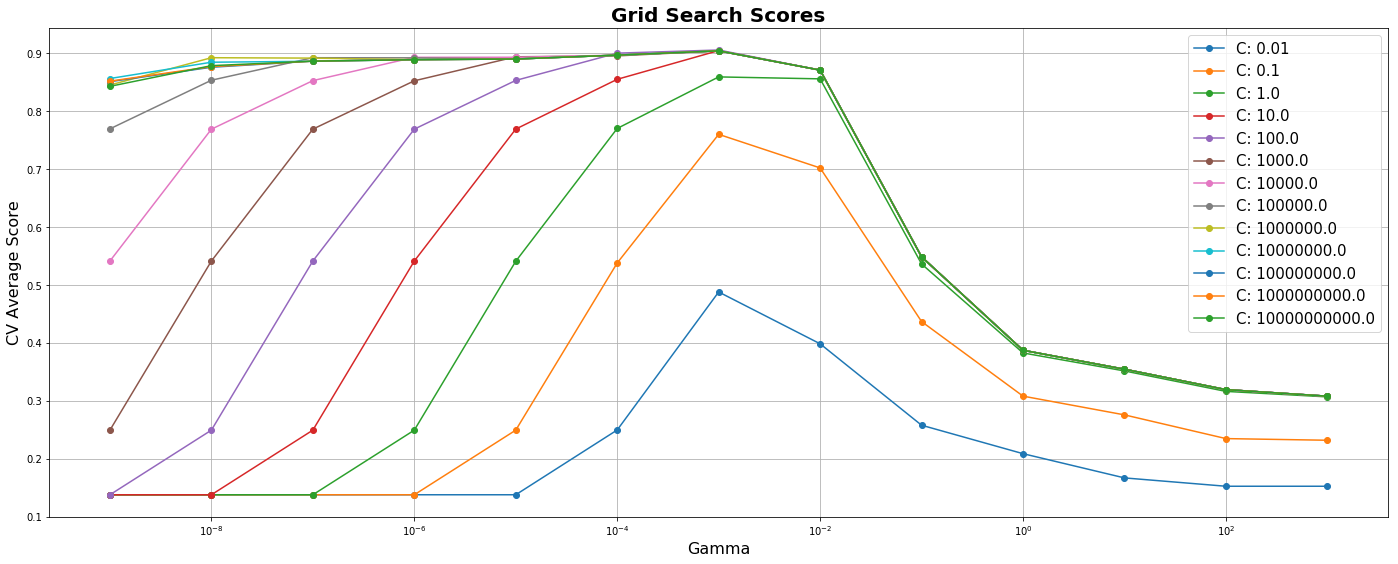

In [14]:
plot_grid_search(top_model.cv_results_,gamma_range,C_range,'Gamma','C')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


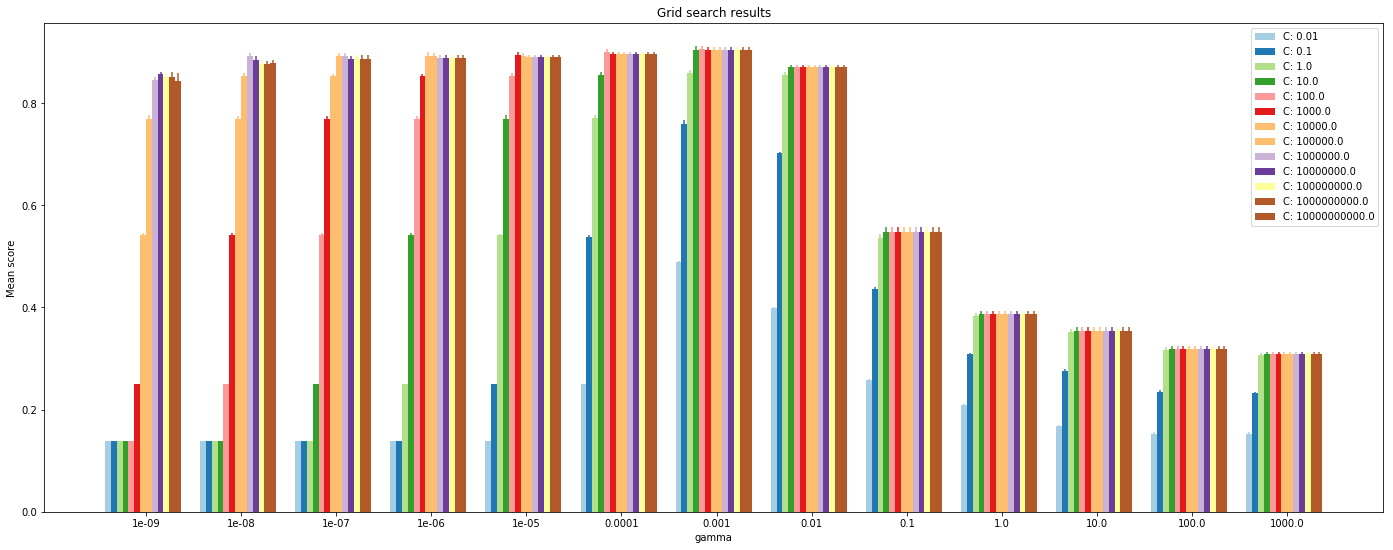

In [15]:
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


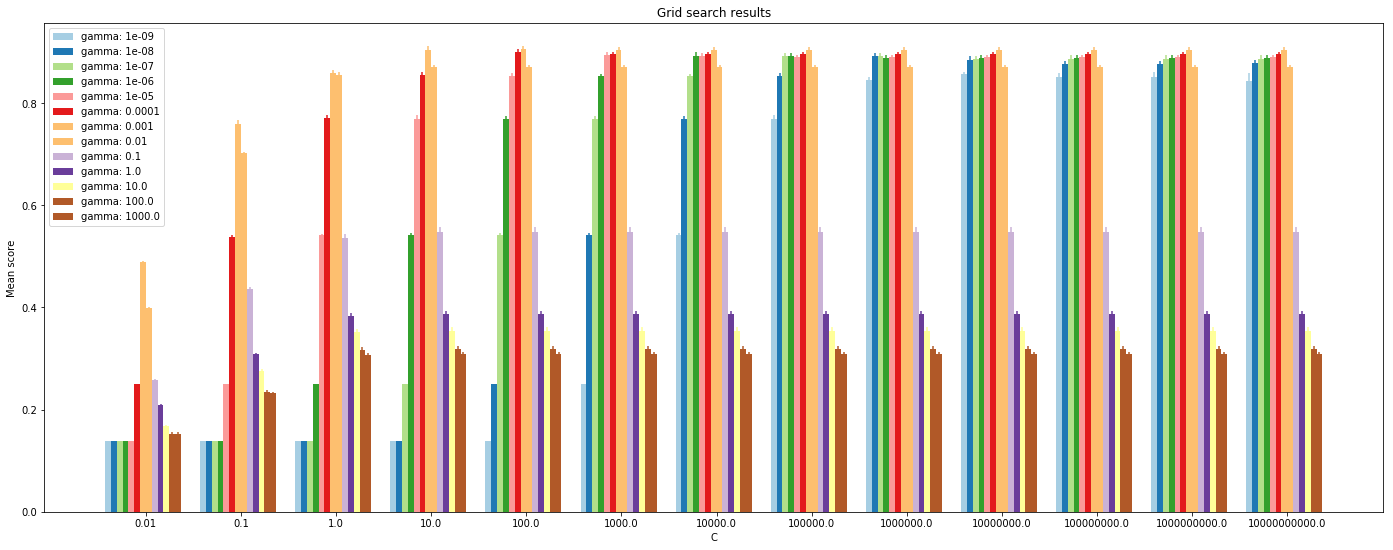

In [16]:
skplot.grid_search(top_model.grid_scores_, change='C', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

In [17]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.SVC(C=top_model.best_params_['C'],gamma=top_model.best_params_['gamma'])
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, resnet50features, y, cv=cv, n_jobs=10, train_sizes=train_sizes)

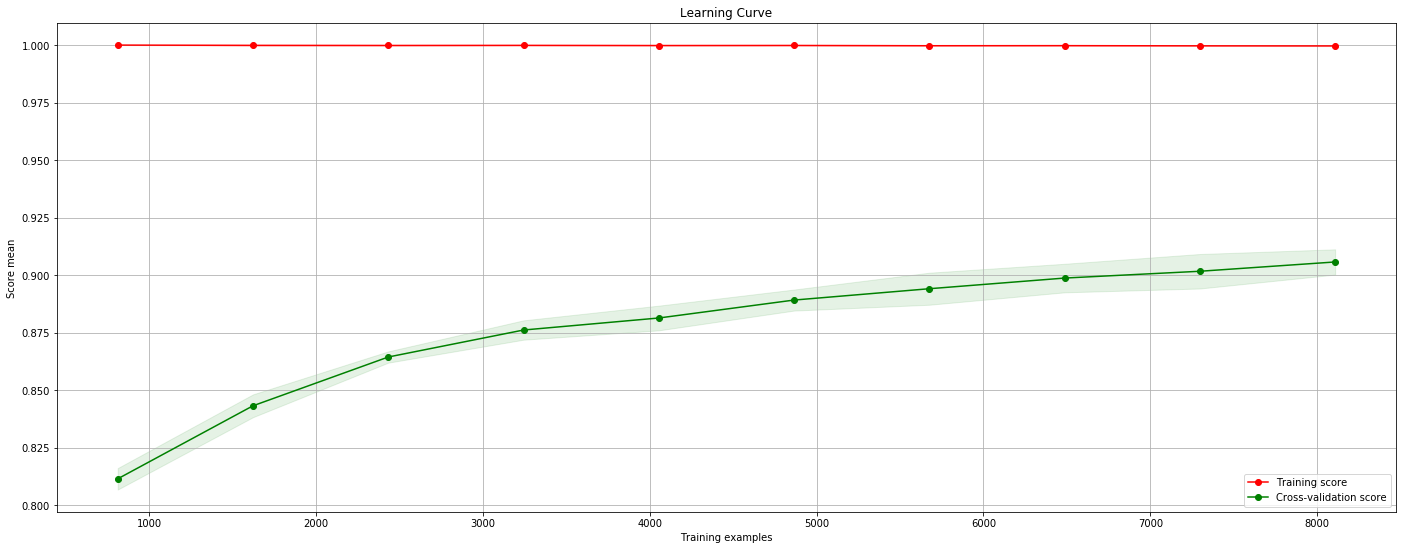

In [18]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()